In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Open quatratically detrended ts data for the 20 CMIP6 models 
data = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_ts_quad_detrend_1900_2015.nc').chunk('auto')

In [3]:
# Calculate anomalies 
clims = data.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anoms = (data.groupby('time.month') - clims).chunk('auto')

In [4]:
# Take DJF average
quarterly_anoms = anoms.resample(time='QS-DEC').mean('time')
djf_anoms = quarterly_anoms.isel(time=slice(0,None,4))

In [5]:
# Read in PCs
pcs = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_pcs.nc')

In [6]:
# Scale PCs to have a standard deviation of 1 
# Flip EOF2 for model MPI-ESM1-2-HR as pattern correlation with HadISST is negative 

pc1 = pcs.sel(mode=1)
pc2 = pcs.sel(mode=2)

norm_1 = []
for m in pc1.model:
    norm_1.append(pc1.sel(model=m)/pc1.sel(model=m).std())
    
pc1 = xr.DataArray(norm_1, coords=pc1.coords, attrs=pc1.attrs)

norm_2 = []
for m in pc2.model:
    if m == 'MPI-ESM1-2-HR':
        norm_2.append(pc2.sel(model=m)*-1/pc2.sel(model=m).std())
    else: norm_2.append(pc2.sel(model=m)/pc2.sel(model=m).std())
    
pc2 = xr.DataArray(norm_2, coords=pc2.coords, attrs=pc2.attrs)

In [7]:
# Calculate E-index and C-index
E = (pc1 - pc2)/np.sqrt(2)
C = (pc1 + pc2)/np.sqrt(2)

In [8]:
# Take DJF average of E-index and C-index
quarterly_E = E.resample(time='QS-DEC').mean('time')
djf_E = quarterly_E.isel(time=slice(0,None,4))

quarterly_C = C.resample(time='QS-DEC').mean('time')
djf_C = quarterly_C.isel(time=slice(0,None,4))

In [9]:
# Linear regression of SST anomalies onto E-index and C-index
E_regress_list = []
C_regress_list = []
for m in djf_anoms.model:
    E_regress_list.append(func.regress_nino(djf_anoms.sel(model=m), djf_E.sel(model=m)))
    C_regress_list.append(func.regress_nino(djf_anoms.sel(model=m), djf_C.sel(model=m)))

In [10]:
E_regressions = xr.concat(E_regress_list, dim='model')
C_regressions = xr.concat(C_regress_list, dim='model')

In [11]:
E_regressions.to_netcdf('/g/data/w40/rl5183/CMIP6_20_E_temp_regressions')
C_regressions.to_netcdf('/g/data/w40/rl5183/CMIP6_20_C_temp_regressions')

In [2]:
E_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_E_temp_regressions')
C_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_C_temp_regressions')

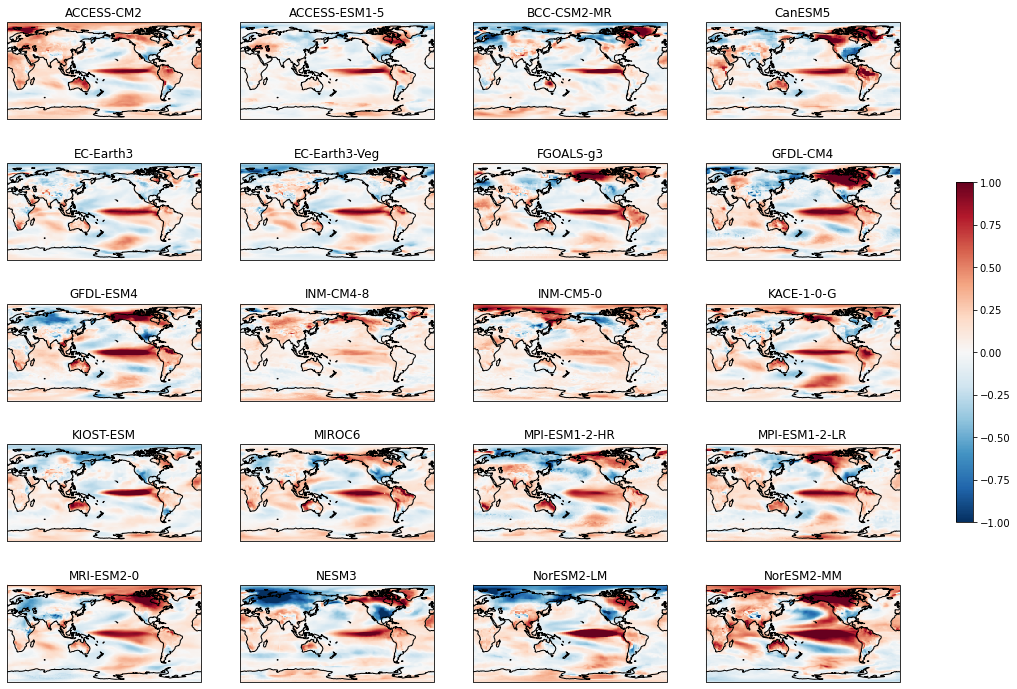

In [3]:
fig = plt.figure(figsize=(20,12.5))
axs = []

columns = 4
rows = 5

for i, m in enumerate(E_regressions.model):
    # Flip pattern so positive regression in tropical pacific
    if E_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        d = E_regressions.sel(model=m)*-1
    else: d = E_regressions.sel(model=m)
    # Plot 
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    C = d.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

plt.savefig('CMIP6_EP_glob_ts_pattern_EOF', bbox_inches='tight', dpi=300)

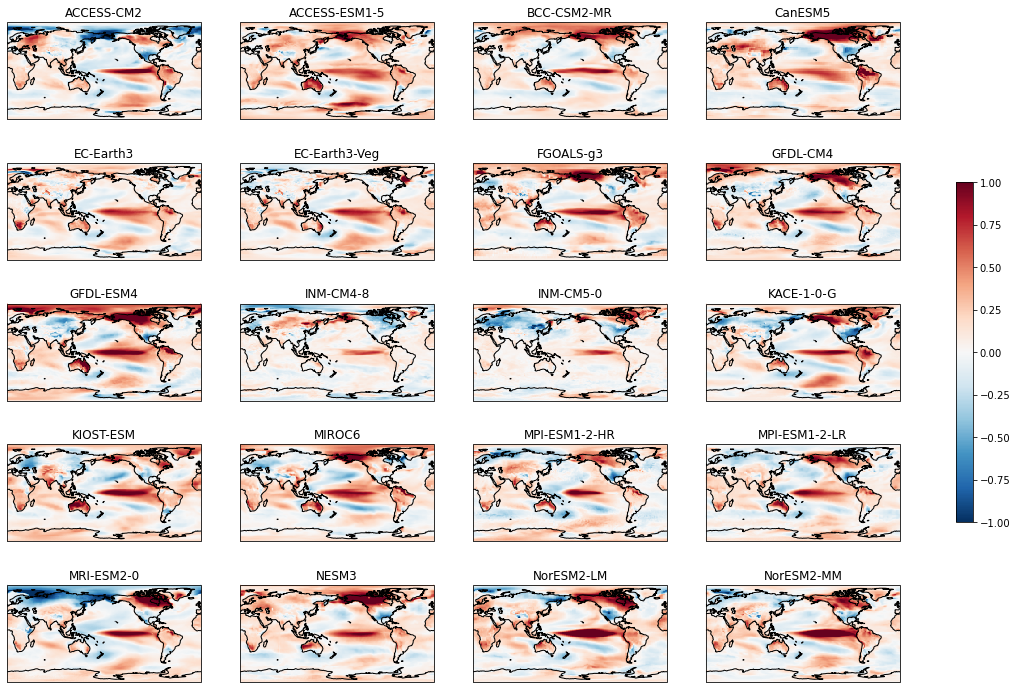

In [4]:
fig = plt.figure(figsize=(20,12.5))
axs = []

columns = 4
rows = 5

for i, m in enumerate(C_regressions.model):
    # Flip pattern so positive regression in tropical pacific
    if C_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        d = C_regressions.sel(model=m)*-1
    else: d = C_regressions.sel(model=m)
    # Plot 
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    C = d.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

plt.savefig('CMIP6_CP_glob_ts_pattern_EOF', bbox_inches='tight', dpi=300)

#### Pattern Correlations

In [3]:
E_regressions_new = []
for m in E_regressions.model:
    if E_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        E_regressions_new.append(E_regressions.sel(model=m)*-1)
    else: E_regressions_new.append(E_regressions.sel(model=m))
E_regressions_new = xr.concat(E_regressions_new, dim='model')

In [4]:
C_regressions_new = []
for m in C_regressions.model:
    if C_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        C_regressions_new.append(C_regressions.sel(model=m)*-1)
    else: C_regressions_new.append(C_regressions.sel(model=m))
C_regressions_new = xr.concat(C_regressions_new, dim='model')

In [2]:
# Read in the quadratically detrended 20CR temp
temp = xr.open_dataarray('/g/data/w40/rl5183/20CR_tmp_ensemble_mean_quad_detrend_1.5x1.5.nc')
# Calculate anomalies
clim = temp.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = (temp.groupby('time.month') - clim)
# Take DJF average
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))
# Open HadISST 
sst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
sst = sst_ds.sst.sel(lat=slice(-15,15)).sel(lon=slice(140,280)).sel(time=slice('1900-01', '2014-12'))
# Quadtratically Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate anomalies 
clim = sst_dt.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = sst_dt.groupby('time.month') - clim
# EOFs
had_eof, had_pcs, had_var = func.eof_and_pcs(anom, 3)
# Scale PCs to have a standrd deviation of 1 
had_pc1 = (had_pcs.sel(mode=1)/had_pcs.sel(mode=1).std())*-1
had_pc2 = had_pcs.sel(mode=2)/had_pcs.sel(mode=2).std()
# Calculate E-index and C-index
had_E = (had_pc1 - had_pc2)/np.sqrt(2)
had_C = (had_pc1 + had_pc2)/np.sqrt(2)
# Take DJF average of E-index and C-index
had_quarterly_E = had_E.resample(time='QS-DEC').mean('time')
had_djf_E = had_quarterly_E.isel(time=slice(0,None,4))

had_quarterly_C = had_C.resample(time='QS-DEC').mean('time')
had_djf_C = had_quarterly_C.isel(time=slice(0,None,4))

# Regression
EP_regress_20CR = func.regress_nino(djf_anom, had_djf_E)
CP_regress_20CR = func.regress_nino(djf_anom, had_djf_C)

In [3]:
E_regress_20CR = EP_regress_20CR.copy()
C_regress_20CR = CP_regress_20CR.copy()

In [6]:
def group_by_lat(data, regions):
    data_by_lat = []
    for reg_name,reg_loc in regions.items():
        data_sliced = data.sel(lat=reg_loc).rename(reg_name)
        data_by_lat.append(data_sliced)
    data_by_lat = xr.merge(data_by_lat)
    return data_by_lat

In [7]:
# Define the regions
regions = {
    "Tropics":slice(-23.5,23.5),
    "Subtropics_NH":slice(23.5,35.5),
    "Subtropics_SH":slice(-35.5, -23.5),
    "Mid_latitudes_NH":slice(35.5, 66.5),
    "Mid_latitudes_SH":slice(-66.5, -35.5),
}

In [8]:
EP_grouped_20CR = group_by_lat(EP_regress_20CR, regions)
CP_grouped_20CR = group_by_lat(CP_regress_20CR, regions)

In [9]:
EP_grouped = []
for m in E_regressions.model:
    EP_grouped.append(group_by_lat(E_regressions_new.sel(model=m), regions))
EP_grouped = xr.concat(EP_grouped, dim='model')

In [10]:
CP_grouped = []
for m in C_regressions.model:
    CP_grouped.append(group_by_lat(C_regressions_new.sel(model=m), regions))
CP_grouped = xr.concat(CP_grouped, dim='model')

In [11]:
Tropics_cor_EP = []
for m in EP_grouped.model:
    Tropics_cor_EP.append(func.pattern_cor(EP_grouped.Tropics.sel(model=m), EP_grouped_20CR.Tropics))
    
Sub_NH_cor_EP = []
for m in EP_grouped.model:
    Sub_NH_cor_EP.append(func.pattern_cor(EP_grouped.Subtropics_NH.sel(model=m), EP_grouped_20CR.Subtropics_NH))
    
Sub_SH_cor_EP = []
for m in EP_grouped.model:
    Sub_SH_cor_EP.append(func.pattern_cor(EP_grouped.Subtropics_SH.sel(model=m), EP_grouped_20CR.Subtropics_SH))
    
Mid_NH_cor_EP = []
for m in EP_grouped.model:
    Mid_NH_cor_EP.append(func.pattern_cor(EP_grouped.Mid_latitudes_NH.sel(model=m), EP_grouped_20CR.Mid_latitudes_NH))
    
Mid_SH_cor_EP = []
for m in EP_grouped.model:
    Mid_SH_cor_EP.append(func.pattern_cor(EP_grouped.Mid_latitudes_SH.sel(model=m), EP_grouped_20CR.Mid_latitudes_SH))

In [12]:
Tropics_cor_CP = []
for m in CP_grouped.model:
    Tropics_cor_CP.append(func.pattern_cor(CP_grouped.Tropics.sel(model=m), CP_grouped_20CR.Tropics))
    
Sub_NH_cor_CP = []
for m in CP_grouped.model:
    Sub_NH_cor_CP.append(func.pattern_cor(CP_grouped.Subtropics_NH.sel(model=m), CP_grouped_20CR.Subtropics_NH))
    
Sub_SH_cor_CP = []
for m in CP_grouped.model:
    Sub_SH_cor_CP.append(func.pattern_cor(CP_grouped.Subtropics_SH.sel(model=m), CP_grouped_20CR.Subtropics_SH))
    
Mid_NH_cor_CP = []
for m in CP_grouped.model:
    Mid_NH_cor_CP.append(func.pattern_cor(CP_grouped.Mid_latitudes_NH.sel(model=m), CP_grouped_20CR.Mid_latitudes_NH))
    
Mid_SH_cor_CP = []
for m in CP_grouped.model:
    Mid_SH_cor_CP.append(func.pattern_cor(CP_grouped.Mid_latitudes_SH.sel(model=m), CP_grouped_20CR.Mid_latitudes_SH))

In [13]:
# Make pandas dataframe 
model_names = E_regressions.model.values
names = list(model_names)

pandas_data = []
for i in np.arange(0,len(names)):
    cell = [names[i], Tropics_cor_EP[i], Sub_NH_cor_EP[i], Sub_SH_cor_EP[i], Mid_NH_cor_EP[i], Mid_SH_cor_EP[i]]
    pandas_data.append(cell)
    
EP_df = pd.DataFrame(pandas_data, columns=['Model', 'Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'])
EP_df.head()

,Model,Tropics,Sub Tropics NH,Sub Tropics SH,Mid Lats NH,Mid Lats SH
0,ACCESS-CM2,0.789040,0.689423,0.825419,0.528513,0.775301
1,ACCESS-ESM1-5,0.778346,0.525564,0.506071,0.191387,0.602955
2,BCC-CSM2-MR,0.697340,0.088035,0.180715,-0.116873,0.045779
3,CanESM5,0.671476,0.474784,0.767032,0.274871,0.708124
4,EC-Earth3,0.875327,0.599291,0.832154,-0.079655,0.747830


In [14]:
%store EP_df

Stored 'EP_df' (DataFrame)


Text(0.5, 1.0, 'EP TEMP EOF')

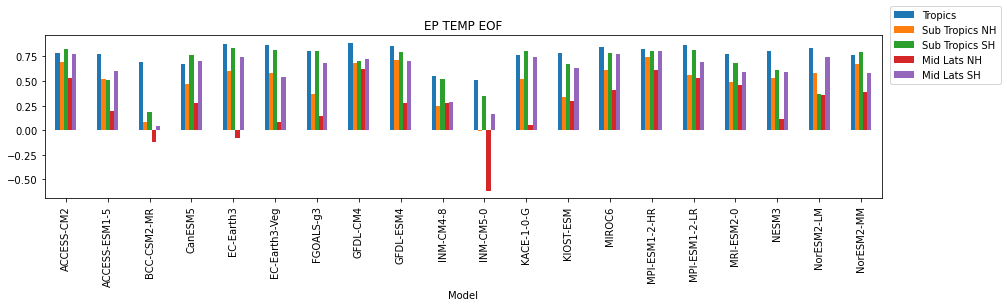

In [46]:
EP_df.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(loc=(1.01,0.7))
plt.title('EP TEMP EOF')

Text(0.5, 1.0, 'EP TEMP EOF')

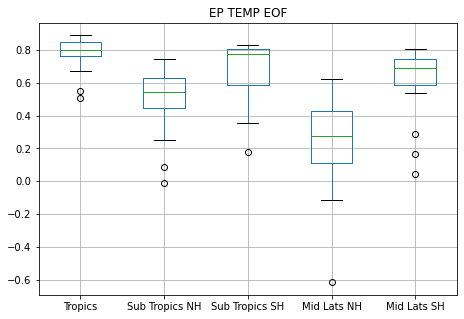

In [45]:
EP_df.boxplot(column=['Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'], figsize=(7.5,5))
plt.title('EP TEMP EOF')

In [15]:
# Make pandas dataframe 
model_names = C_regressions.model.values
names = list(model_names)

pandas_data = []
for i in np.arange(0,len(names)):
    cell = [names[i], Tropics_cor_CP[i], Sub_NH_cor_CP[i], Sub_SH_cor_CP[i], Mid_NH_cor_CP[i], Mid_SH_cor_CP[i]]
    pandas_data.append(cell)
    
CP_df = pd.DataFrame(pandas_data, columns=['Model', 'Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'])
CP_df.head()

,Model,Tropics,Sub Tropics NH,Sub Tropics SH,Mid Lats NH,Mid Lats SH
0,ACCESS-CM2,0.739032,0.558416,0.795702,0.234445,0.801069
1,ACCESS-ESM1-5,0.725854,0.583601,0.832911,0.439821,0.836186
2,BCC-CSM2-MR,0.792563,0.783607,0.805006,0.578494,0.818047
3,CanESM5,0.623775,0.793771,0.866320,0.614319,0.609382
4,EC-Earth3,0.837549,0.453101,0.812190,0.012265,0.836729


In [16]:
%store CP_df

Stored 'CP_df' (DataFrame)


Text(0.5, 1.0, 'CP TEMP EOF')

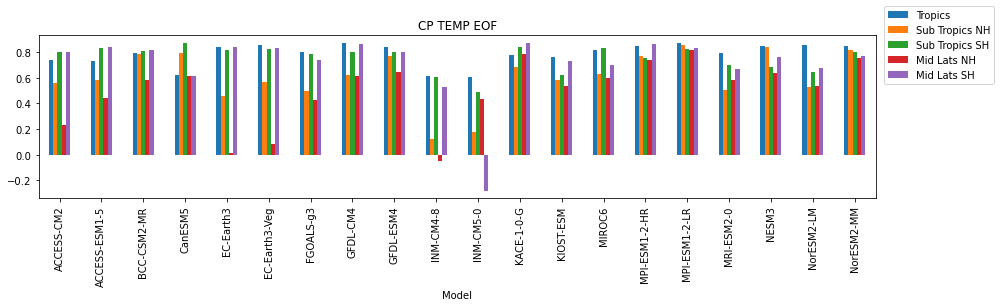

In [47]:
CP_df.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(loc=(1.01,0.7))
plt.title('CP TEMP EOF')

Text(0.5, 1.0, 'CP TEMP EOF')

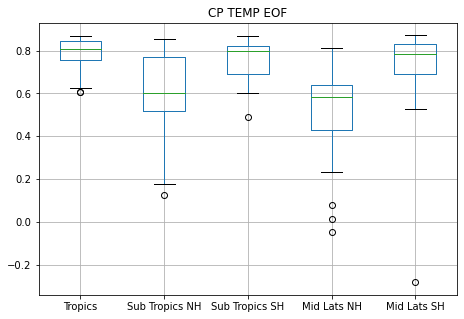

In [48]:
CP_df.boxplot(column=['Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'], figsize=(7.5,5))
plt.title('CP TEMP EOF')

Text(0, 0.5, 'CP')

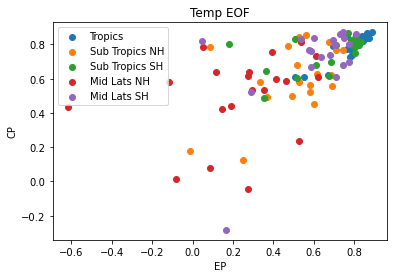

In [51]:
plt.scatter(EP_df['Tropics'], CP_df['Tropics'], label='Tropics')
plt.scatter(EP_df['Sub Tropics NH'], CP_df['Sub Tropics NH'], label='Sub Tropics NH')
plt.scatter(EP_df['Sub Tropics SH'], CP_df['Sub Tropics SH'], label='Sub Tropics SH')
plt.scatter(EP_df['Mid Lats NH'], CP_df['Mid Lats NH'], label='Mid Lats NH')
plt.scatter(EP_df['Mid Lats SH'], CP_df['Mid Lats SH'], label='Mid Lats SH')
plt.title('Temp EOF')
plt.legend()
plt.xlabel('EP')
plt.ylabel('CP')

In [16]:
%store -r had_EP_sst_eof
%store -r had_CP_sst_eof

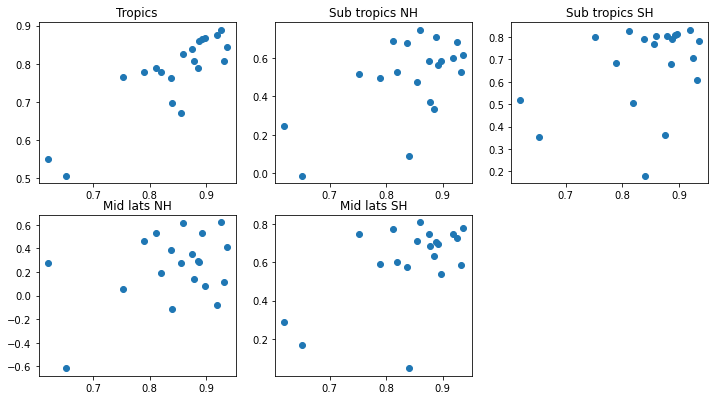

In [17]:
fig = plt.figure(figsize=(12,6.5))
ax = fig.add_subplot(2,3,1)
ax.scatter(had_EP_sst_eof, Tropics_cor_EP)
ax.title.set_text('Tropics')
ax = fig.add_subplot(2,3,2)
ax.scatter(had_EP_sst_eof, Sub_NH_cor_EP)
ax.title.set_text('Sub tropics NH')
ax = fig.add_subplot(2,3,3)
ax.scatter(had_EP_sst_eof, Sub_SH_cor_EP)
ax.title.set_text('Sub tropics SH')
ax = fig.add_subplot(2,3,4)
ax.scatter(had_EP_sst_eof, Mid_NH_cor_EP)
ax.title.set_text('Mid lats NH')
ax = fig.add_subplot(2,3,5)
ax.scatter(had_EP_sst_eof, Mid_SH_cor_EP)
ax.title.set_text('Mid lats SH')

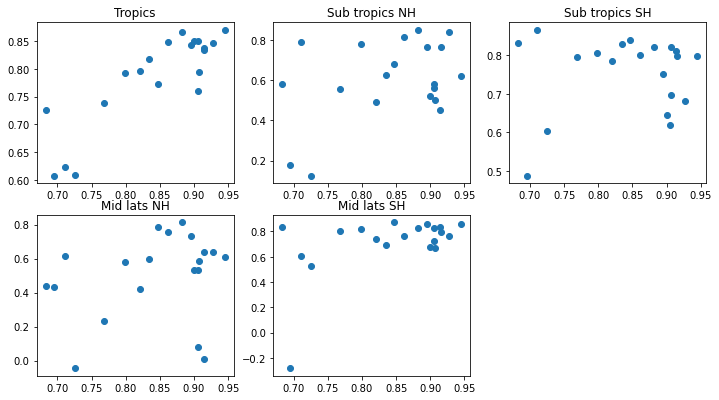

In [19]:
fig = plt.figure(figsize=(12,6.5))
ax = fig.add_subplot(2,3,1)
ax.scatter(had_CP_sst_eof, Tropics_cor_CP)
ax.title.set_text('Tropics')
ax = fig.add_subplot(2,3,2)
ax.scatter(had_CP_sst_eof, Sub_NH_cor_CP)
ax.title.set_text('Sub tropics NH')
ax = fig.add_subplot(2,3,3)
ax.scatter(had_CP_sst_eof, Sub_SH_cor_CP)
ax.title.set_text('Sub tropics SH')
ax = fig.add_subplot(2,3,4)
ax.scatter(had_CP_sst_eof, Mid_NH_cor_CP)
ax.title.set_text('Mid lats NH')
ax = fig.add_subplot(2,3,5)
ax.scatter(had_CP_sst_eof, Mid_SH_cor_CP)
ax.title.set_text('Mid lats SH')

#### Do models with better temp teleconnection also have better precip teleconnection?

In [15]:
EP_temp = EP_df.copy()
CP_temp = CP_df.copy()

In [16]:
%store EP_temp
%store CP_temp

Stored 'EP_temp' (DataFrame)
Stored 'CP_temp' (DataFrame)
